In [1]:
using SchwarzChristoffel

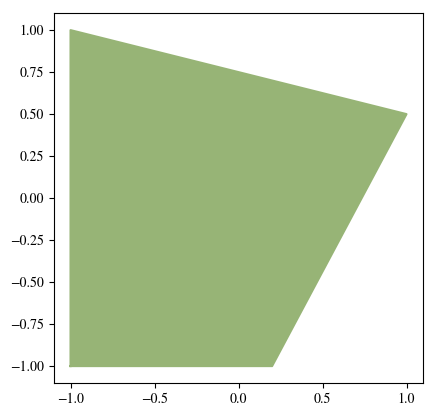

In [2]:
p = Polygon([-1.0,0.2,1.0,-1.0],[-1.0,-1.0,0.5,1.0])
plot(p)

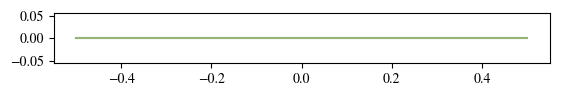

In [2]:
p = Polygon([-0.5,0.5],[0,0])
plot(p)

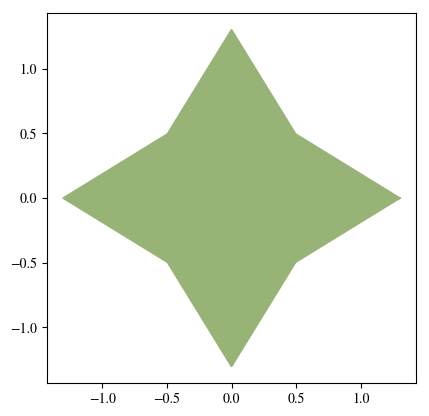

In [5]:
n = 4; dθ = 2π/(2n)
θ = collect(0:dθ:2π-dθ)
w = (1+0.3cos.(n*θ)).*exp.(im*θ)
p = Polygon(w)
plot(p)

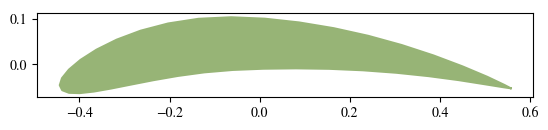

In [5]:
w = naca4(0.1,0.4,0.12;len=1)
p = Polygon(w)
plot(p)

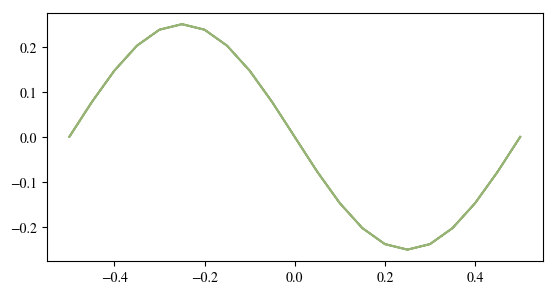

In [8]:
ht = 0.25
nwave = 2
nseg = 20
x = 1.0
len = 1.0
dx = len/nseg
vert = Complex128[]
for j = 1:nseg+1
    push!(vert,x+im*ht*sin(π*nwave*x))
    x -= dx
end
vert = [vert;flipdim(vert[2:end-1],1)]
vert -=mean(vert)
p = Polygon(vert);
plot(p)

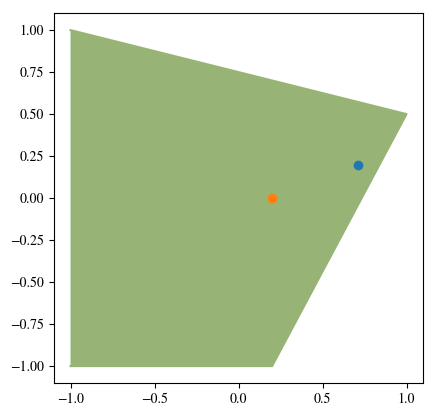

1×2 BitArray{2}:
 true  true

In [6]:
z = [0.71+im*0.2 0.2+im*0]
plot(p)
PyPlot.plot(real.(z),imag.(z),marker="o")
isinpoly.(z,p,1e-5)

In [3]:
m = ExteriorMap(p)

Schwarz-Christoffel map of unit circle to exterior of polygon with 4 vertices


In [4]:
summary(m)

Schwarz-Christoffel map of unit circle to exterior of polygon with 4 vertices
   vertices: (-1.0,-1.0), (0.2,-1.0), (1.0,0.5), (-1.0,1.0), 
   interior angles/π: 0.5, 0.656, 0.422, 0.422, 
   prevertices on circle: (1.0,0.0), (0.3764,-0.9265), (-0.9024,-0.4309), (-0.1868,0.9824), 
   prevertex angles/π: -0.7291, -0.3519, 0.1291, 0.7111, 
   constant = 0.6722 + 0.7669im, accuracy = 1.0e-8, 
   number of multipole coefficients = 12


In [5]:
conformal_grid(m)

LoadError: [91mtype ExteriorMap has no field ccoeff[39m

In [11]:
m = ExteriorMap(p;tol=1e-12)

Exterior map with
   vertices: (-1.0,-1.0), (0.2,-1.0), (1.0,0.5), (-1.0,1.0), 
   interior angles/π: 0.5, 0.656, 0.422, 0.422, 
   prevertices on circle: (1.0,0.0), (0.3764,-0.9265), (-0.9024,-0.4309), (-0.1868,0.9824), 
   constant = 0.6722 + 0.7669im, accuracy = 1.0e-12, 
   number of multipole coefficients = 12


In [9]:
prev, C = parameters(m)

(Complex{Float64}[1.0+0.0im, 0.376406-0.926455im, -0.902383-0.430935im, -0.186756+0.982406im], 0.6722109863402015 + 0.7668866078562682im)

In [42]:
area(m)/ccoeff[1]

2.3639234904370356 - 0.0im

In [45]:
ccoeff, dcoeff = coefficients(m);

In [46]:
ccoeff

14-element Array{Complex{Float64},1}:
      1.12786+0.0im        
 -1.42493e-16+4.60899e-17im
 -3.13044e-17-3.13044e-16im
  6.26088e-17-3.86088e-16im
  3.30026e-16-3.13044e-17im
   5.0087e-17+1.37739e-16im
 -3.96522e-17-3.13044e-17im
  9.98759e-17-5.96274e-18im
     0.202134+1.75453e-14im
 -7.43133e-18-1.09806e-17im
  1.41027e-17+8.39839e-17im
 -6.77881e-17+1.23623e-16im
 -1.93438e-16+7.8648e-18im 
 -3.88048e-17-9.57267e-17im

In [29]:
dm = DerivativeMap(m)

d/dζ of Schwarz-Christoffel map of unit circle to exterior of polygon with 4 vertices



In [5]:
zeta = [0.1,0.5-0.75im,-0.25-0.3im]
dz, ddz = dm(zeta;inside=true);
dz

3-element Array{Complex{Float64},1}:
  67.2068+76.6284im 
 -1.11666+0.544576im
  3.99129-5.30641im 

In [26]:
ζ = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
#ζ = [0.1,0.5-0.75im,-0.25-0.3im]
#ζ = 1.0+3.0im
#ζ = 0.5-0.75im
m(ζ)

3-element Array{Complex{Float64},1}:
   0.81614+3.02956im 
  -2.25237-2.08523im 
 -0.333104+0.975837im

In [31]:
#ζ = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
#ζ = [0.1,0.5-0.75im,-0.25-0.3im]
ζ = 1.0+3.0im
#ζ = 0.5-0.75im
dz,ddz = dm(ζ)
dz

1.0305280030434558 + 0.0044499240190600114im

The entries in `c` correspond as follows: `c[1]`$\rightarrow c_{1}$, `c[2]`$\rightarrow c_{0}$, `c[3]`$\rightarrow c_{-1}$, etc

In [16]:
zeta = collect(1.1:0.1:2.0) + 0.1im
dz,ddz = evalderiv(zeta,m)
dz

10-element Array{Complex{Float64},1}:
 0.872356-0.394475im 
 0.901724-0.289355im 
 0.925562-0.217994im 
 0.944059-0.168264im 
 0.958255-0.132657im 
  0.96919-0.106522im 
 0.977695-0.0869128im
 0.984389-0.0719115im
 0.989723-0.0602376im
 0.994025-0.0510144im

In [11]:
z = evaluate(zeta,m)

3-element Array{Complex{Float64},1}:
   0.81614+3.02956im 
  -2.25237-2.08523im 
 -0.333104+0.975837im

In [8]:
dz, ddz = zeros(5)

5-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [26]:
p = SchwarzChristoffel.Polygon([-1.0,0.2,1.0,-1.0],[-1.0,-1.0,0.5,1.0])
  map = SchwarzChristoffel.ExteriorMap(p)
zeta = [0.1,0.5-0.75im,-0.25-0.3im]
(dz,ddz) = SchwarzChristoffel.evalderiv(zeta,map,true)

(Complex{Float64}[67.2068+76.6284im, -1.11666+0.544576im, 3.99129-5.30641im], Complex{Float64}[-1344.35-1534.06im, 1.39046+2.522im, -6.58311-33.6604im])

In [32]:
dz[3]

3.991294815021402 - 5.306406953713079im

In [7]:
mean([sum(ccoeff.*zeta[i].^(1:-1:-m.ncoeff))-z[i] for i = 1:length(zeta)])

2.5518320641274943e-5 + 8.985895672545634e-5im

In [2]:
a = 1
b = 0.1
c = Complex128[0.5(a+b),0,0.5(a-b)]
m = PowerMap(c)

Power series map


In [4]:
summary(m)

multipole coefficients:
  c₁ = 0.55 + 0.0im, 
  c₀ = 0.0 + 0.0im, 
  c₋ᵢ = 0.45 + 0.0im, i = 1:1


In [11]:
ζ = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
m(ζ)

3-element Array{Complex{Float64},1}:
   0.595+1.515im   
 -1.2125-0.9875im  
     0.0+0.195909im

In [10]:
typeof(m.ps).parameters[1]

1

In [8]:
dm = DerivativeMap(m)

d/dζ of Power series map



In [9]:
ζ = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
dz, ddz = dm(ζ)
dz
ζ = 1.0+3.0im
dz, ddz = dm(ζ)
dz

1.02 + 0.015im

In [3]:
zeta = [1.0+3.0im,-2.0-2.0im,0.0+1.1im]
dz,ddz = evalderiv(zeta,m)
dz[3]

0.921900826446281 + 0.0im

In [4]:
evalderiv(1.0+3.0im,m)

(0.5860000000000001 + 0.027im, -0.052 + 0.036000000000000004im)

In [21]:
c = Complex128[1,0,1/4]
m = PowerMap(c)

Power series map


In [18]:
Jmoment(m)

1.4759202286564845

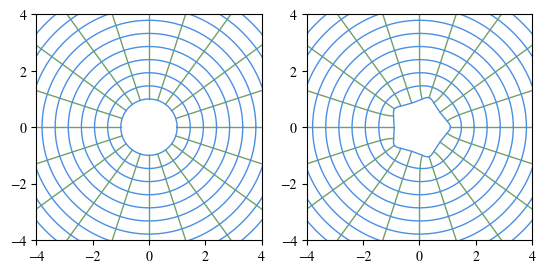

In [3]:
conformal_grid(m)

In [4]:
length(m)

200

In [4]:
Jmoment(m)

1.5707963267948966

In [3]:
area(m)

3.141592653589793

In [22]:
ζ = [1.0+3.0im,-2.0-2.0im,0.0+1.1im];
m(ζ)

3-element Array{Complex{Float64},1}:
   1.025+2.925im   
 -2.0625-1.9375im  
     0.0+0.872727im

In [15]:
struct FirstDerivativeMap{M}
    m :: M
end
(dm :: FirstDerivativeMap)(ζ) = SchwarzChristoffel.evalderiv(ζ,dm.m)[1]

In [16]:
ζ = 1.0-2.0im
dm = FirstDerivativeMap(m)
dm(ζ)

0.6040000000000001 - 0.07200000000000001im